In [4]:
# Import necessary libraries including NumPy, Pandas, Matplotlib, Seaborn, TensorFlow, and PIL.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [5]:
# Define a path to image data using pathlib.
path = Path("UTKFace/")

# Load image filenames and shuffle them
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
# Load image file names and shuffle them.

np.random.seed(10)
np.random.shuffle(filenames)

# Parse age and gender labels from file names

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

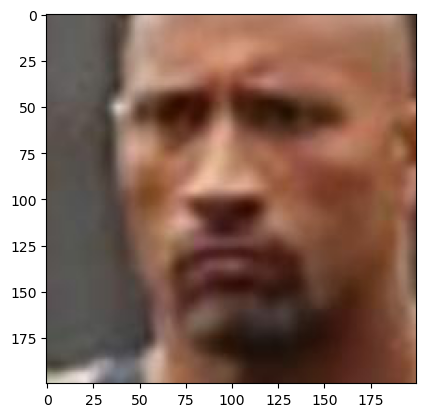

In [18]:
# Create a Pandas DataFrame to store the information.
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

gender_dict = {0: "Male", 1: "Female"}
df = df.astype({'age': 'float32', 'gender': 'int32'})

# Convert image paths to images using PIL and displays a sample image.
img = Image.open("UTKFace/"+df.image[2000])
plt.imshow(img)

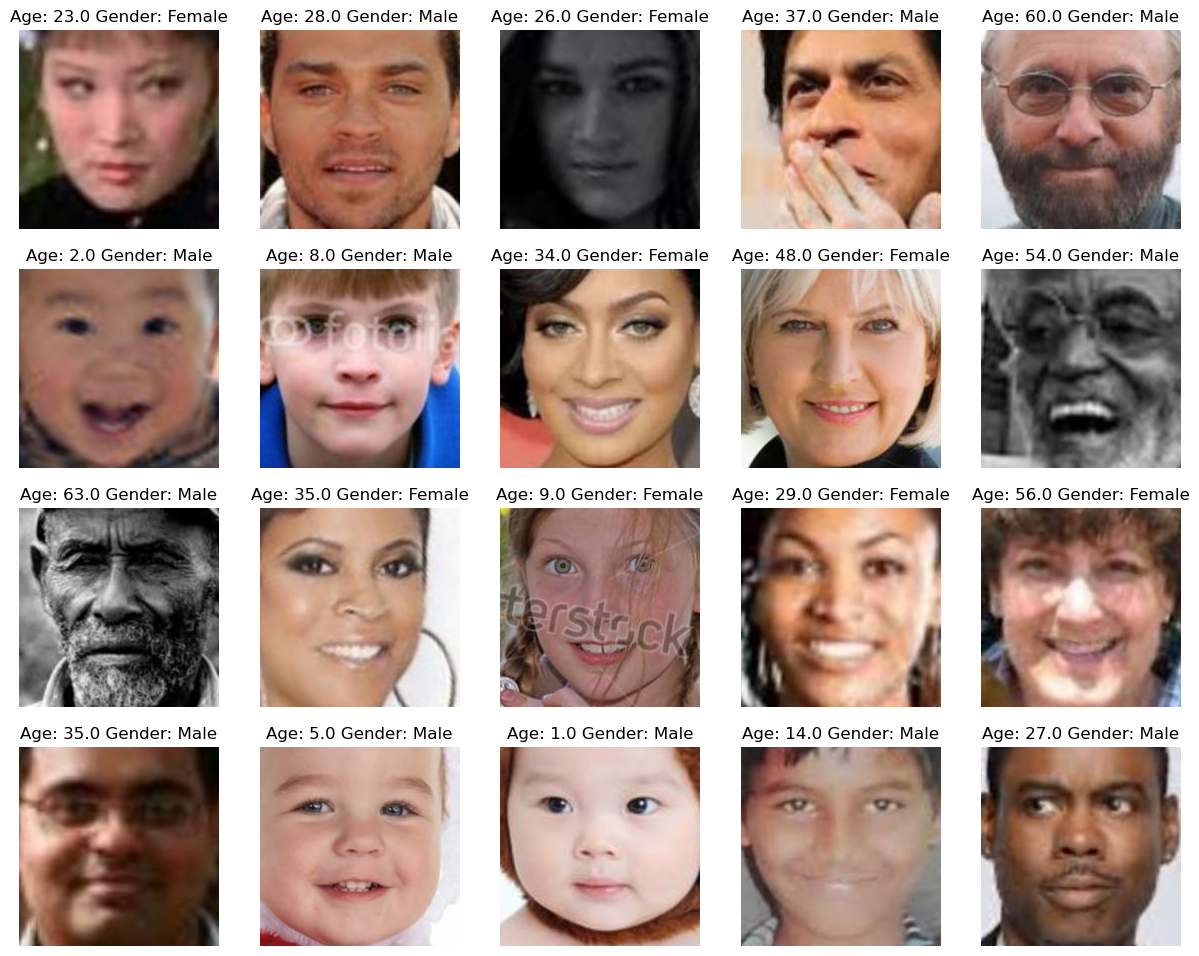

In [12]:
# Select a subset of the DataFrame for visualization.

files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img("UTKFace/" + file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [14]:
# Split the dataset into training and testing sets.

train, test = train_test_split(df, test_size=0.85, random_state=42)

In [16]:
# Load and preprocess images for training.
x_train = []
for file in train.image:
    img = load_img("UTKFace/" + file, color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

In [17]:
x_train.shape

(3556, 128, 128, 1)

In [20]:
# Normalize Data
x_train = x_train/255

# Prepare gender and age labels along with input size for the model
y_gender = np.array(train.gender)
y_age = np.array(train.age)

input_size = (128,128,1)

In [22]:
# Define the architecture of the convolutional neural network model
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [24]:
# Compile the model with loss functions, optimizer, and metrics
model.compile(loss=['binary_crossentropy', 'mae'], 
              optimizer='adam', 
              metrics=['accuracy', 'mae'])


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
# Train the model on the training data

model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=30, validation_split= 0.1)

Epoch 1/30
320/320 [==============================] - 27s 80ms/step - loss: 17.2396 - gender_output_loss: 0.6957 - age_output_loss: 16.5439 - gender_output_accuracy: 0.6206 - gender_output_mae: 0.4513 - age_output_accuracy: 0.0481 - age_output_mae: 16.5439 - val_loss: 24.7304 - val_gender_output_loss: 0.6589 - val_age_output_loss: 24.0714 - val_gender_output_accuracy: 0.6685 - val_gender_output_mae: 0.4810 - val_age_output_accuracy: 0.0534 - val_age_output_mae: 24.0714
Epoch 2/30
320/320 [==============================] - 25s 78ms/step - loss: 13.1874 - gender_output_loss: 0.4949 - age_output_loss: 12.6925 - gender_output_accuracy: 0.7713 - gender_output_mae: 0.3324 - age_output_accuracy: 0.0441 - age_output_mae: 12.6925 - val_loss: 11.6336 - val_gender_output_loss: 0.4962 - val_age_output_loss: 11.1374 - val_gender_output_accuracy: 0.7191 - val_gender_output_mae: 0.3467 - val_age_output_accuracy: 0.0534 - val_age_output_mae: 11.1374
Epoch 3/30
320/320 [==============================] 

In [30]:
model_history.history.keys()

dict_keys(['loss', 'gender_output_loss', 'age_output_loss', 'gender_output_accuracy', 'gender_output_mae', 'age_output_accuracy', 'age_output_mae', 'val_loss', 'val_gender_output_loss', 'val_age_output_loss', 'val_gender_output_accuracy', 'val_gender_output_mae', 'val_age_output_accuracy', 'val_age_output_mae'])

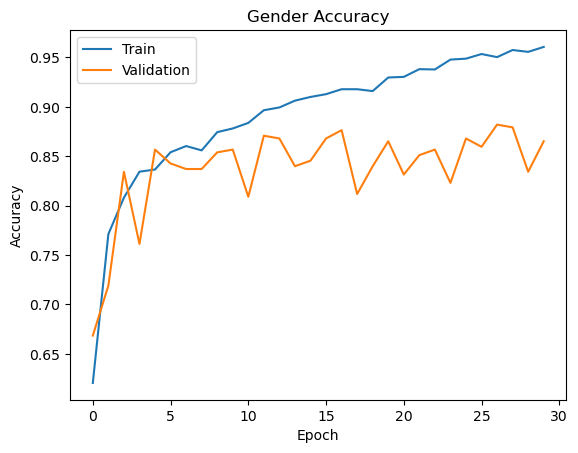

In [32]:
# Plot training and validation accuracies for gender prediction

plt.plot(model_history.history['gender_output_accuracy'])
plt.plot(model_history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


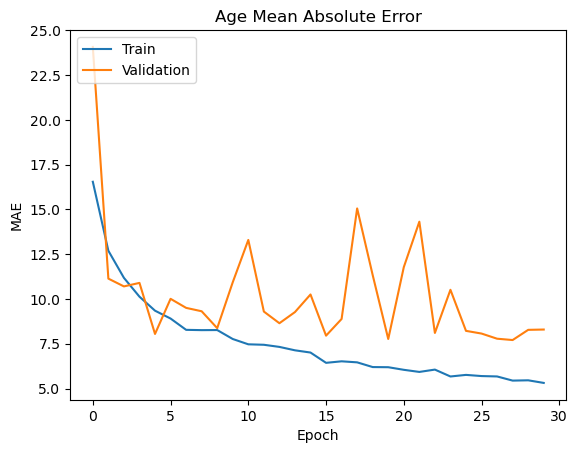

In [38]:
# Plot training and validation MAE for age prediction

plt.plot(model_history.history['age_output_mae'])
plt.plot(model_history.history['val_age_output_mae'])
plt.title('Age Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Original: Gender =  Female  Age =  24.0
1/1 [==============================] - 0s 30ms/step
Prediction: Gender =  Female  Age =  20


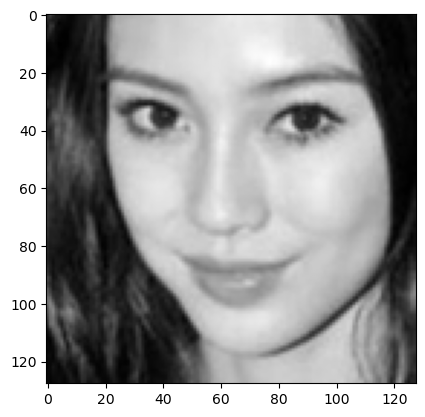

In [40]:
# Predictions on sample images and display original and predicted gender and age alongside the images

index=29
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  35.0
1/1 [==============================] - 0s 23ms/step
Prediction: Gender =  Female  Age =  33


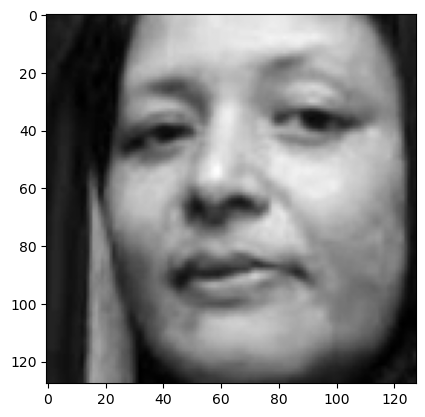

In [42]:
# Predictions on sample images and display original and predicted gender and age alongside the images

index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

In [46]:
model.save("gender_age_model.h5")
